<a href="https://colab.research.google.com/github/mlEngAnu/text-classification/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [4]:
# loading data file from local folder
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train (1).csv


In [59]:
# Importing Data from file
df = pd.read_csv('train (1).csv')
df_test = pd.read_csv('test.csv')

In [61]:
df = pd.concat([df, df_test])

In [62]:
df

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival
...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support
3076,How many countries do you support?,country_support
3077,What countries do you do business in?,country_support
3078,What are the countries you operate in.,country_support


In [63]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

154002

In [64]:
df.category.unique()

array(['card_arrival', 'card_linking', 'exchange_rate',
       'card_payment_wrong_exchange_rate', 'extra_charge_on_statement',
       'pending_cash_withdrawal', 'fiat_currency_support',
       'card_delivery_estimate', 'automatic_top_up', 'card_not_working',
       'exchange_via_app', 'lost_or_stolen_card', 'age_limit',
       'pin_blocked', 'contactless_not_working',
       'top_up_by_bank_transfer_charge', 'pending_top_up',
       'cancel_transfer', 'top_up_limits',
       'wrong_amount_of_cash_received', 'card_payment_fee_charged',
       'transfer_not_received_by_recipient',
       'supported_cards_and_currencies', 'getting_virtual_card',
       'card_acceptance', 'top_up_reverted',
       'balance_not_updated_after_cheque_or_cash_deposit',
       'card_payment_not_recognised', 'edit_personal_details',
       'why_verify_identity', 'unable_to_verify_identity',
       'get_physical_card', 'visa_or_mastercard', 'topping_up_by_card',
       'disposable_card_limits', 'compromised_card

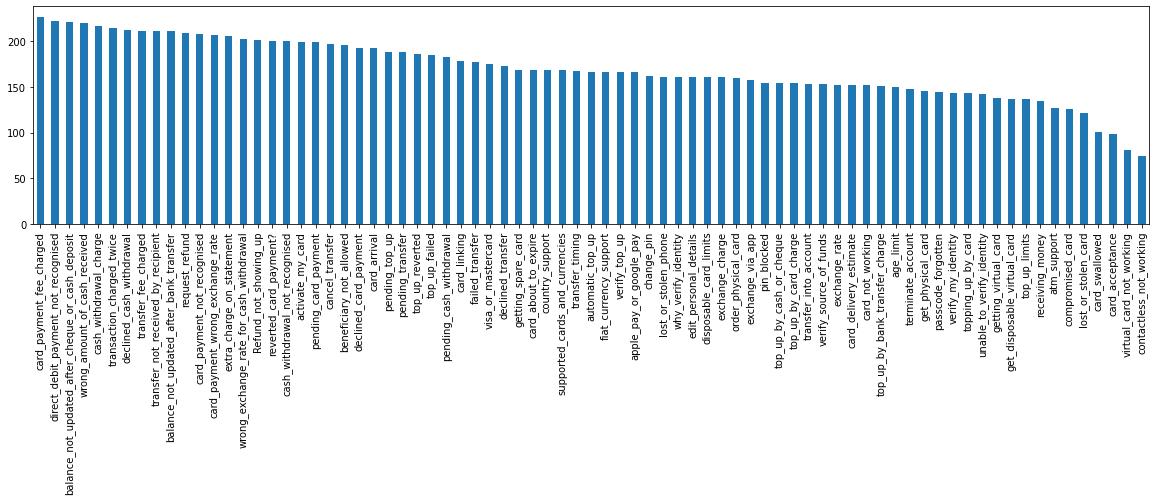

In [65]:
my_tags = df.category.unique()
plt.figure(figsize=(20,4))
df.category.value_counts().plot(kind='bar');

In [66]:
def print_plot(index):
    example = df[df.index == index][['text', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [67]:
import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
df['text'] = df['text'].apply(clean_text)

In [69]:
print_plot(500)

exchange rate different expected
Tag: card_payment_wrong_exchange_rate


In [70]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

69499

In [71]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [73]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8170700636942675
                                                  precision    recall  f1-score   support

                                    card_arrival       0.87      0.79      0.83        68
                                    card_linking       0.97      0.95      0.96        76
                                   exchange_rate       1.00      0.89      0.94        55
                card_payment_wrong_exchange_rate       0.79      1.00      0.88        50
                       extra_charge_on_statement       0.92      0.83      0.87        29
                         pending_cash_withdrawal       0.90      0.91      0.91        47
                           fiat_currency_support       0.65      0.74      0.69        70
                          card_delivery_estimate       0.85      0.86      0.85        71
                                automatic_top_up       0.76      0.96      0.85        49
                                card_not_working       0.78      0.97  

# Support Vector Machine

In [74]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [75]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8030573248407643
                                                  precision    recall  f1-score   support

                                    card_arrival       0.82      0.91      0.86        68
                                    card_linking       0.89      0.95      0.92        76
                                   exchange_rate       0.89      1.00      0.94        55
                card_payment_wrong_exchange_rate       0.71      1.00      0.83        50
                       extra_charge_on_statement       0.83      0.86      0.85        29
                         pending_cash_withdrawal       0.79      0.94      0.85        47
                           fiat_currency_support       0.72      0.66      0.69        70
                          card_delivery_estimate       0.77      0.86      0.81        71
                                automatic_top_up       0.83      0.92      0.87        49
                                card_not_working       0.73      0.95  

# Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [77]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8524840764331211
                                                  precision    recall  f1-score   support

                                    card_arrival       0.90      0.84      0.87        68
                                    card_linking       1.00      0.95      0.97        76
                                   exchange_rate       1.00      0.96      0.98        55
                card_payment_wrong_exchange_rate       0.93      1.00      0.96        50
                       extra_charge_on_statement       0.88      0.97      0.92        29
                         pending_cash_withdrawal       0.96      0.94      0.95        47
                           fiat_currency_support       0.70      0.73      0.71        70
                          card_delivery_estimate       0.90      0.80      0.85        71
                                automatic_top_up       0.80      0.90      0.85        49
                                card_not_working       0.90      0.92  

# Keras Neural Network

In [78]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [79]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 9158
Test size: 3925


In [85]:
X = df.text
y = df.category
train_posts, test_posts, train_tags, test_tags = train_test_split(X, y, test_size=0.3, random_state = 42)

In [81]:
train_posts = df['text'][:train_size]
train_tags = df['category'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['category'][train_size:]

In [86]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [87]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [88]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [89]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [90]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (9158, 1000)
x_test shape: (3925, 1000)
y_train shape: (9158, 77)
y_test shape: (3925, 77)


In [91]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [97]:
batch_size = 32
epochs = 10

In [98]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [99]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
258/258 [==============================] - 4s 12ms/step - loss: 2.9919 - accuracy: 0.4771 - val_loss: 1.3815 - val_accuracy: 0.7598
Epoch 2/10
258/258 [==============================] - 4s 14ms/step - loss: 0.9312 - accuracy: 0.8140 - val_loss: 0.6841 - val_accuracy: 0.8515
Epoch 3/10
258/258 [==============================] - 4s 14ms/step - loss: 0.5434 - accuracy: 0.8714 - val_loss: 0.5328 - val_accuracy: 0.8712
Epoch 4/10
258/258 [==============================] - 2s 8ms/step - loss: 0.4001 - accuracy: 0.9029 - val_loss: 0.4687 - val_accuracy: 0.8821
Epoch 5/10
258/258 [==============================] - 2s 8ms/step - loss: 0.3169 - accuracy: 0.9208 - val_loss: 0.4331 - val_accuracy: 0.8821
Epoch 6/10
258/258 [==============================] - 3s 12ms/step - loss: 0.2632 - accuracy: 0.9316 - val_loss: 0.4137 - val_accuracy: 0.8865
Epoch 7/10
258/258 [==============================] - 2s 8ms/step - loss: 0.2289 - accuracy: 0.9404 - val_loss: 0.4104 - val_accuracy: 0.8821
Ep

In [100]:
score = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

123/123 [==============================] - 1s 4ms/step - loss: 0.4200 - accuracy: 0.8744
Test accuracy: 0.8743948936462402
